# Figure 5: Receptive Fields

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import h5py
import scipy

import EIANN.utils as ut
import EIANN.plot as pt
from EIANN.generate_figures import *

pt.update_plot_defaults()

%load_ext autoreload
%autoreload 2

In [ ]:
def generate_receptive_field_figure(population, model_list, model_dict_all, figure_name):
    fig = plt.figure(figsize=(6.5, 5))
    axes = gs.GridSpec(nrows=3, ncols=4, figure=fig,
                        left=0.07,right=0.94,
                        top=0.93, bottom = 0.1,
                        wspace=0.5, hspace=0.2,
                        height_ratios=[3,1,1])

    root_dir = ut.get_project_root()

    model_dict_all["vanBP"]["display_name"] = "Feedforward ANN \n Backprop"
    model_dict_all["bpLike_WT_hebbdend"]["display_name"] = "Dendritic Target \nPropagation (LDS)"
    model_dict_all["bpDale_fixed"]["display_name"] = "EIANN \n Backprop"
    model_dict_all["HebbWN_topsup"]["display_name"] = "EIANN \n Hebb + Weight Norm."

    for col, model_key in enumerate(model_list):
        model_dict = model_dict_all[model_key]
        network_name = model_dict['config'].split('.')[0]
        hdf5_path = root_dir + f"/EIANN/data/model_hdf5_plot_data/plot_data_{network_name}.h5"
        with h5py.File(hdf5_path, 'r') as f:
            data_dict = f[network_name]
            print(f"Generating plots for {model_dict['label']}")
            example_seed = model_dict['seeds'][-1] # example seed to plot
            
            # fig.suptitle(f"{population} {example_seed}", fontsize=10, x=0.5, y=1.01, fontweight='bold')

            ###########################
            # Example receptive fields
            ###########################
            receptive_fields = torch.tensor(np.array(data_dict[example_seed][f"final_receptive_fields"][population]))
            num_units = 50
            temp_ax = fig.add_subplot(axes[0, col])
            pos = temp_ax.get_position()
            
            rf_axes = fig.add_gridspec(10,5,left=pos.x0, right=pos.x1, bottom=pos.y0, top=pos.y1, wspace=0.1, hspace=0.1)
            ax_list = []
            for j in range(num_units):
                _ax = fig.add_subplot(rf_axes[j])
                ax_list.append(_ax)

            average_pop_activity_dict = data_dict[example_seed]['average_pop_activity_dict']
            preferred_classes = np.argmax(average_pop_activity_dict[population], axis=0)
            im = pt.plot_receptive_fields(receptive_fields, sort=True, ax_list=ax_list, preferred_classes=preferred_classes, class_labels=False)
            height = _ax.get_position().y1 - _ax.get_position().y0
            width = _ax.get_position().x1 - _ax.get_position().x0
            cax = fig.add_axes([_ax.get_position().x1+width/5, _ax.get_position().y0, width/5, 1.5*height])
            fig.colorbar(im, cax=cax, orientation='vertical')
            ax_list[2].set_title(model_dict["display_name"])
            for label in range(10):
                temp_ax.text(-0.1, label*0.101+0.04, str(9-label), fontsize=7, ha='center', va='center')
            if col==0:
                temp_ax.set_title('Unit tuning\n(label of max avg. activity)', x=-0.31, rotation=90, y=0.45, ha='center', va='center', fontsize=7)
            temp_ax.axis('off')

            # Draw an arrow below the x-axis
            new_ax = fig.add_axes([temp_ax.get_position().x0, temp_ax.get_position().y0-0.035, temp_ax.get_position().x1-temp_ax.get_position().x0, 0.05])
            new_ax.set_ylim(-0.5, 0.5)
            new_ax.axis('off')
            new_ax.arrow(0, 0, 1, 0, head_width=0.2, head_length=0.1, facecolor='k', edgecolor='k', linewidth=1)     
            new_ax.text(0.5, -0.3, "Example units", fontsize=7, ha='center', va='center')                          

            ###############################
            # RF quantification: structure
            ###############################
            ax_structure = fig.add_subplot(axes[1, col])
            structure_all_seeds = {'initial': [], 'final': []}
            for seed in data_dict:
                structure_all_seeds['initial'].append(data_dict[seed][f"metrics_dict"][population]['structure_initial'][:].flatten())
                structure_all_seeds['final'].append(data_dict[seed][f"metrics_dict"][population]['structure_final'][:].flatten())
            mean_initial = np.mean(structure_all_seeds['initial'], axis=1)        
            mean_final = np.mean(structure_all_seeds['final'], axis=1)
            structure_all_seeds['initial'] = np.array(structure_all_seeds['initial']).flatten()
            structure_all_seeds['final'] = np.array(structure_all_seeds['final']).flatten()

            # Create violin plot with initial and final distributions
            parts = ax_structure.violinplot([structure_all_seeds['initial'], structure_all_seeds['final']], positions=[0, 1], 
                                            showmeans=False, showmedians=False, showextrema=False, widths=0.8, side='both')
            parts['bodies'][0].set_alpha(0.7)
            parts['bodies'][0].set_facecolor("darkgray")
            parts['bodies'][1].set_alpha(0.7)
            parts['bodies'][1].set_facecolor(model_dict['color'])
            ax_structure.set_xticks([0, 1])
            ax_structure.set_xticklabels(['Initial', 'Final'])

            # Scatter on a point with the mean and error bar
            initial_mean = np.mean(mean_initial)
            final_mean = np.mean(mean_final)
            ax_structure.scatter(0, initial_mean, color='tomato', marker='o', s=5, zorder=5, edgecolors='w', linewidth=0.3)
            ax_structure.scatter(1, final_mean, color='tomato', marker='o', s=5, zorder=5, edgecolors='w', linewidth=0.3)
            ax_structure.set_ylim(-0.03, 1)
            if col == 0:
                ax_structure.set_ylabel('RF Structure')

            ###############################
            # RF quantification: pixel KDE
            ###############################
            ax_hist = fig.add_subplot(axes[2, col])
            final_receptive_fields = []
            for seed in data_dict:
                final_receptive_fields.append(data_dict[seed]['final_receptive_fields'][population][:])
            final_receptive_fields = np.array(final_receptive_fields)

            # Normalize pixel values (-1, 1)
            max_pixel_value = np.max(np.abs(final_receptive_fields))
            final_receptive_fields = final_receptive_fields / max_pixel_value
            
            # Create KDE curves
            x_range = np.concatenate([np.linspace(-1, -1e-12, 200), np.linspace(0, 1, 200)])
            final_kde = scipy.stats.gaussian_kde(final_receptive_fields.flatten(), bw_method=0.1)
            final_density = final_kde(x_range)
            final_density = final_density / np.sum(final_density) # normalize so the area under the curve is 1
            
            # Plot KDE
            ax_hist.plot(x_range, final_density, color=model_dict['color'], label='Final', alpha=0.8, linewidth=0.5)
            ax_hist.fill_between(x_range, final_density, alpha=0.1, color=model_dict['color'])
            ax_hist.set_xlabel('RF pixel value')
            if col == 0:
                ax_hist.set_ylabel('Probability Density')
            ax_hist.set_xlim([-0.6, 0.6])

    fig.savefig(root_dir + f"/EIANN/figures/{figure_name}_{population}.png", dpi=300)
    fig.savefig(root_dir + f"/EIANN/figures/{figure_name}_{population}.svg", dpi=300)

Generating plots for Feedforward ANN 
 Backprop
Generating plots for EIANN 
 Backprop
Generating plots for EIANN 
 Hebb + Weight Norm.
Generating plots for Dendritic Target 
Propagation (LDS)


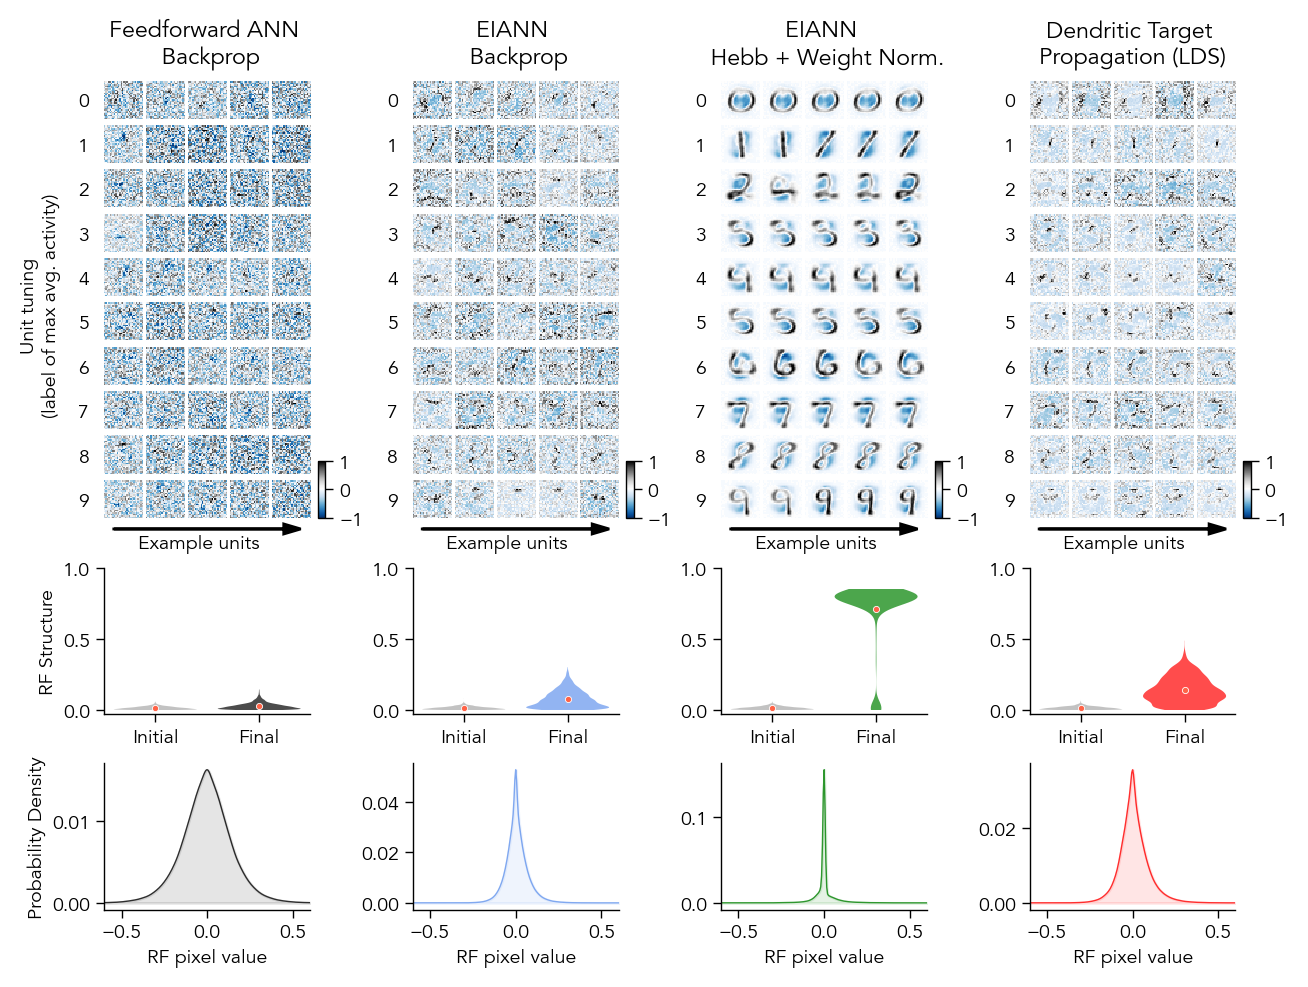

In [ ]:
figure_name = "Fig5_receptive_fields"
population = 'H1E'

model_list = ["vanBP", "bpDale_fixed", "HebbWN_topsup", "bpLike_WT_hebbdend"]
model_dict_all = load_model_dict()
generate_hdf5_all_seeds(model_list, model_dict_all, variables_to_save=["metrics_dict", "final_receptive_fields", "average_pop_activity_dict"], recompute=None)

generate_receptive_field_figure(population, model_list, model_dict_all, figure_name)